In [ ]:
# Assignment3: song profiling
# Given the information collected in the previous assignment,
# build some song categories based on the lyrics or/and the melodic information available in the data.
# For this assignment, you can use any software/package you want!

In [1]:
import pandas as pd
import numpy as np
df_tracksClean = pd.read_csv('DataWithDateImputation.csv')
df_artistsClean = pd.read_csv('output2.csv')

In [ ]:
print("df_tracks:", df_tracksClean.columns)
print("df_artists:", df_artistsClean.columns)

In [ ]:
# Lyrical Features: swear_IT, swear_EN, n_sentences, n_tokens, char_per_tok
# Melodic/Acoustic Features: bpm,loudness,rms,rolloff,flux,flatnessspectral_complexity, pitch
# Metadata: year, popularity, duration_ms --> for cotext (possible dimensions)

In [2]:
#Rename for an easier merge later on
df_artistsClean.rename(columns={'id_author': 'id_artist'}, inplace=True)

In [3]:
from sklearn.preprocessing import StandardScaler

# Select Features
feature_cols = [
    'id', 'swear_IT', 'swear_EN', 'n_sentences', 'n_tokens', 'char_per_tok',
    'bpm', 'loudness', 'rms', 'rolloff', 'flux', 'flatness',
    'spectral_complexity', 'pitch', 'popularity', 'duration_ms', 'year'
]
df_features = df_tracksClean[feature_cols].copy()

# Identify features for scaling (numerical features that are not IDs/metadata)
scaling_features = [
    'swear_IT', 'swear_EN', 'n_sentences', 'n_tokens', 'char_per_tok',
    'bpm', 'loudness', 'rms', 'rolloff', 'flux', 'flatness',
    'spectral_complexity', 'pitch', 'popularity', 'duration_ms'
]


In [4]:
# 1.2. Handle Missing Data
# Fill 'year' NaNs (e.g., with median) before dropping other NaNs
if df_features['year'].isnull().any():
    df_features['year'].fillna(df_features['year'].median(), inplace=True)

# Drop rows with NaN values in the key scaling features
initial_rows = len(df_features)
df_features.dropna(subset=scaling_features, inplace=True)
print(f"Dropped {initial_rows - len(df_features)} rows due to missing key features.")

# Separate the data to be scaled
X = df_features[scaling_features]

Dropped 71 rows due to missing key features.


C:\Users\user\AppData\Local\Temp\ipykernel_62368\3733443420.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_features['year'].fillna(df_features['year'].median(), inplace=True)


In [5]:
# 1.3. Scale Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=scaling_features, index=df_features.index)


--- 2. Clustering (K-Means) ---


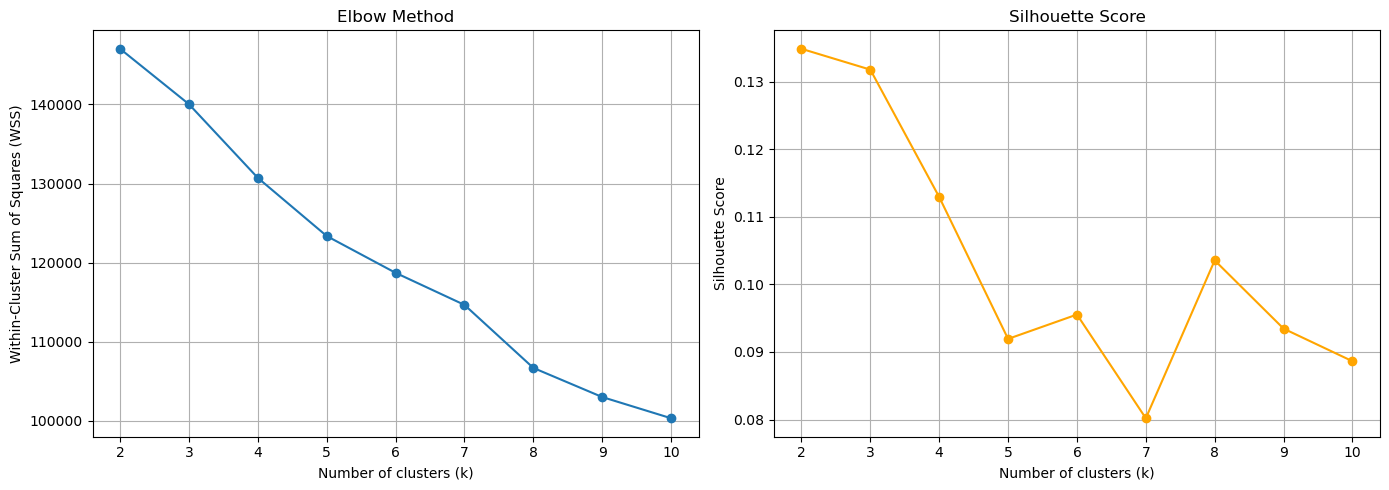

In [6]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

## --- 2. Unsupervised Clustering (K-Means) ---

print("\n--- 2. Clustering (K-Means) ---")

# 2.1. Determine Optimal Number of Clusters (Elbow Method)
# Calculate WCSS for a range of K values
wcss = []  # Within-Cluster Sum of Squares
sil_scores = []  # Silhouette Scores
k_range = range(2, 11)

for i in k_range:
    # Set n_init='auto' to silence warnings in newer scikit-learn versions
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init='auto')
    labels = kmeans.fit_predict(X_scaled_df)
    wcss.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X_scaled_df, labels))

# Plot WCSS and Silhouette Scores
plt.figure(figsize=(14,5))

# Elbow method
plt.subplot(1,2,1)
plt.plot(k_range, wcss, marker='o')
plt.title("Elbow Method")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Within-Cluster Sum of Squares (WSS)")
plt.grid(True)

# Silhouette Score
plt.subplot(1,2,2)
plt.plot(k_range, sil_scores, marker='o', color='orange')
plt.title("Silhouette Score")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)

plt.tight_layout()
plt.show()


Optimal K selected: 3


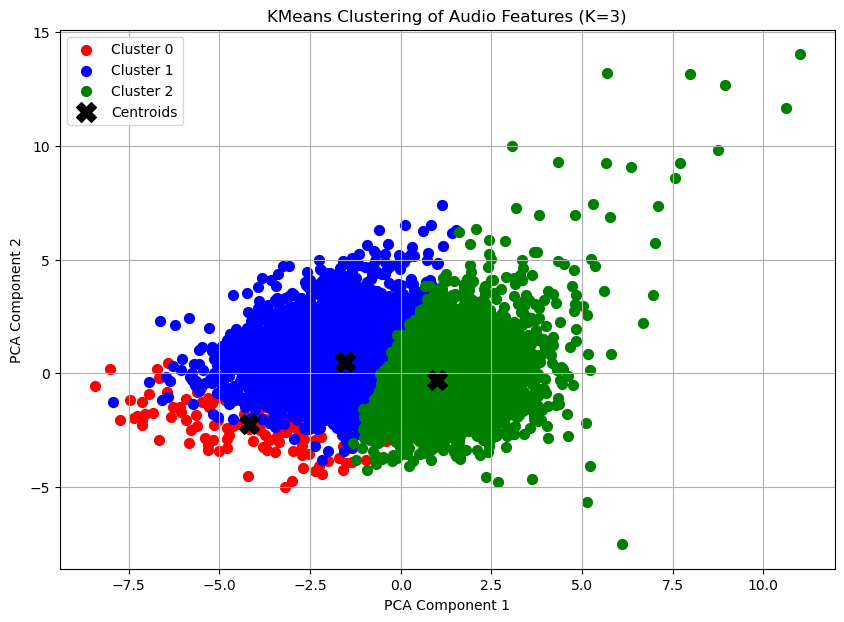

Cluster
0     118
1    4194
2    6780
Name: count, dtype: int64


In [12]:
from sklearn.decomposition import PCA

# 2.2. Perform K-Means Clustering
# Based on visual inspection of the Elbow plot, let's select K=5 as an example optimal point.
OPTIMAL_K = 3
print(f"\nOptimal K selected: {OPTIMAL_K}")

kmeans_final = KMeans(n_clusters=OPTIMAL_K, init='k-means++', random_state=42, n_init='auto')
clusters = kmeans_final.fit_predict(X_scaled_df)

# Add cluster labels back to the original (unscaled) feature dataframe
df_features['Cluster'] = clusters

#Visualization with pca
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled_df)

plt.figure(figsize=(10,7))

colors = ['red', 'blue', 'green', 'orange']

for i in range(OPTIMAL_K):
    plt.scatter(
        X_pca[clusters == i, 0], 
        X_pca[clusters == i, 1],
        s=50,
        c=colors[i],
        label=f'Cluster {i}'
    )

# centroids transformed to PCA space
centroids_df = pd.DataFrame(kmeans_final.cluster_centers_, columns=X_scaled_df.columns)
centroids_pca = pca.transform(centroids_df)

plt.scatter(
    centroids_pca[:, 0],
    centroids_pca[:, 1],
    s=200,
    c='black',
    marker='X',
    label='Centroids'
)

plt.title(f"KMeans Clustering of Audio Features (K={OPTIMAL_K})")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid(True)
plt.show()

print(df_features['Cluster'].value_counts().sort_index())

In [13]:
## --- 3. Profile and Categorize Clusters ---

print("\n--- 3. Cluster Profiling and Categorization ---")

# 3.1. Analyze Cluster Characteristics
# Calculate the mean of the original features for every cluster
cluster_profiles = df_features.groupby('Cluster')[scaling_features].mean().reset_index()

# Calculate the overall mean for comparison
overall_mean = df_features[scaling_features].mean()

print("\n--- Cluster Mean Profiles (Compared to Overall Mean) ---")
print("Overall Means:\n", overall_mean.round(2))
print("-" * 50)
print("Cluster Profiles:")
print(cluster_profiles.round(2))


--- 3. Cluster Profiling and Categorization ---

--- Cluster Mean Profiles (Compared to Overall Mean) ---
Overall Means:
 swear_IT                    2.35
swear_EN                    0.71
n_sentences                59.40
n_tokens                  496.68
char_per_tok                4.06
bpm                       114.14
loudness                   24.24
rms                         0.22
rolloff                  1617.22
flux                        1.26
flatness                    0.86
spectral_complexity        27.42
pitch                    2255.96
popularity                 32.55
duration_ms            203432.34
dtype: float64
--------------------------------------------------
Cluster Profiles:
   Cluster  swear_IT  swear_EN  n_sentences  n_tokens  char_per_tok     bpm  \
0        0      0.00      0.00         4.75     25.20          7.30  110.60   
1        1      1.68      0.42        51.42    426.08          4.04  113.63   
2        2      2.81      0.91        65.30    548.55        

In [ ]:
# Cluster 0: Very low values for swear_IT and swear_EN, 
# very few sentences and tokens. This cluster likely represents 
# short, clean tracks with minimal explicit content.

# Cluster 1: Values closer to the overall mean, slightly lower bpm
#  and moderate text length. This cluster likely represents 
# medium-length, moderately energetic tracks.

# Cluster 2: Higher values for n_tokens and n_sentences, 
# bpm slightly above average, and more audio complexity.
# This cluster likely represents longer, more energetic, and complex tracks.

Category_Name
Long Energetic Complex Tracks    6780
Medium-Length Moderate Energy    4194
Clean Short Tracks                118
Name: count, dtype: int64


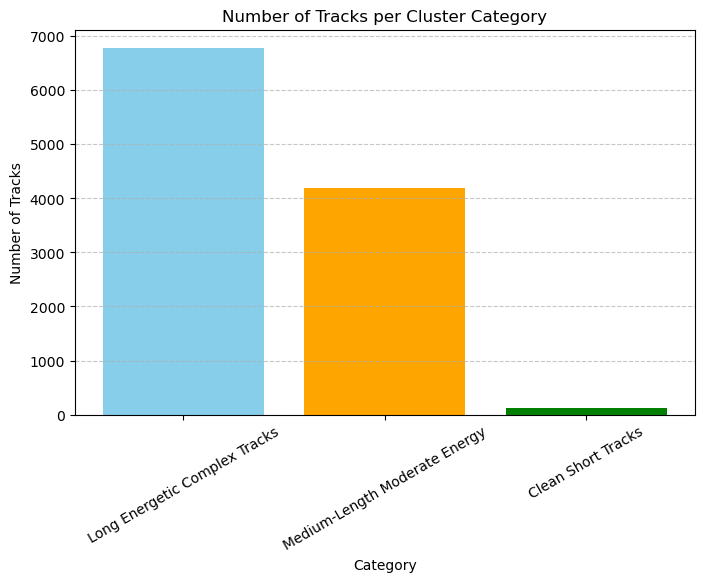

In [21]:
# 3.2. Naming and Categorization (Manual Interpretation)
CLUSTER_NAMES = {
    0: "Clean Short Tracks",
    1: "Medium-Length Moderate Energy",
    2: "Long Energetic Complex Tracks"
}
df_features['Category_Name'] = df_features['Cluster'].map(CLUSTER_NAMES)

print(df_features['Category_Name'].value_counts())

# Count of tracks per category
category_counts = df_features['Category_Name'].value_counts()

# Matplotlib version
plt.figure(figsize=(8,5))
plt.bar(category_counts.index, category_counts.values, color=['skyblue', 'orange', 'green'])
plt.title("Number of Tracks per Cluster Category")
plt.ylabel("Number of Tracks")
plt.xlabel("Category")
plt.xticks(rotation=30)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [26]:
df_features.columns

Index(['id', 'swear_IT', 'swear_EN', 'n_sentences', 'n_tokens', 'char_per_tok',
       'bpm', 'loudness', 'rms', 'rolloff', 'flux', 'flatness',
       'spectral_complexity', 'pitch', 'popularity', 'duration_ms', 'year',
       'Cluster', 'Category_Name'],
      dtype='object')

In [ ]:
#  Made a mistake and removed it from df_feature so now ill add it back
artist_id_map = df_tracksClean[['id', 'id_artist']].set_index('id')

#I use 'id' to merge back the 'id_artist' into df_features
df_features = df_features.merge(
    artist_id_map.reset_index(),
    on='id',
    how='left'
)

# Verify that 'id_artist' has been added back
if 'id_artist' in df_features.columns:
    print("SUCCESS: 'id_artist' è stata aggiunta a df_features.")
else:
    print("ERROR: La colonna 'id_artist' non è stata aggiunta correttamente.")

SUCCESS: 'id_artist' è stata aggiunta a df_features.


In [28]:
## --- 4. Integration with Artist Data (Enhancement) ---

print("\n--- 4. Artist Profile Integration ---")

# 4.1. Merge Cluster Data with Artist Metadata
# Merge clustered tracks with artist gender/nationality data
df_full_data = df_features[['id', 'id_artist', 'Cluster', 'Category_Name']].merge(
    df_artistsClean[['id_artist', 'gender', 'nationality']],
    on='id_artist',
    how='left'
)


--- 4. Artist Profile Integration ---


In [29]:
# 4.2. Analyze Dominant Artist Characteristics per Category

print("\nDominant Gender Distribution per Category:")
gender_analysis = df_full_data.groupby('Category_Name')['gender'].value_counts(normalize=True).mul(100).unstack(fill_value=0)
print(gender_analysis.sort_values(by=gender_analysis.columns[0], ascending=False).head())

print("\nTop 3 Nationalities per Category:")
for name, group in df_full_data.groupby('Category_Name'):
    top_nationalities = group['nationality'].value_counts(normalize=True).mul(100).head(3)
    print(f"\nCategory: {name}")
    print(top_nationalities.round(1).to_string())

# Final dataframe containing all features and the assigned category
df_song_profiles = df_features.merge(df_full_data[['id', 'gender', 'nationality']], on='id', how='left')
print("\nFinal Song Profiles created successfully (df_song_profiles).")


Dominant Gender Distribution per Category:
gender                                F          M
Category_Name                                     
Medium-Length Moderate Energy  6.009390  93.990610
Long Energetic Complex Tracks  4.982517  95.017483
Clean Short Tracks             3.361345  96.638655

Top 3 Nationalities per Category:

Category: Clean Short Tracks
nationality
Italia       71.9
Argentina    28.1

Category: Long Energetic Complex Tracks
nationality
Italia       99.8
Argentina     0.2

Category: Medium-Length Moderate Energy
nationality
Italia       99.8
Argentina     0.2

Final Song Profiles created successfully (df_song_profiles).


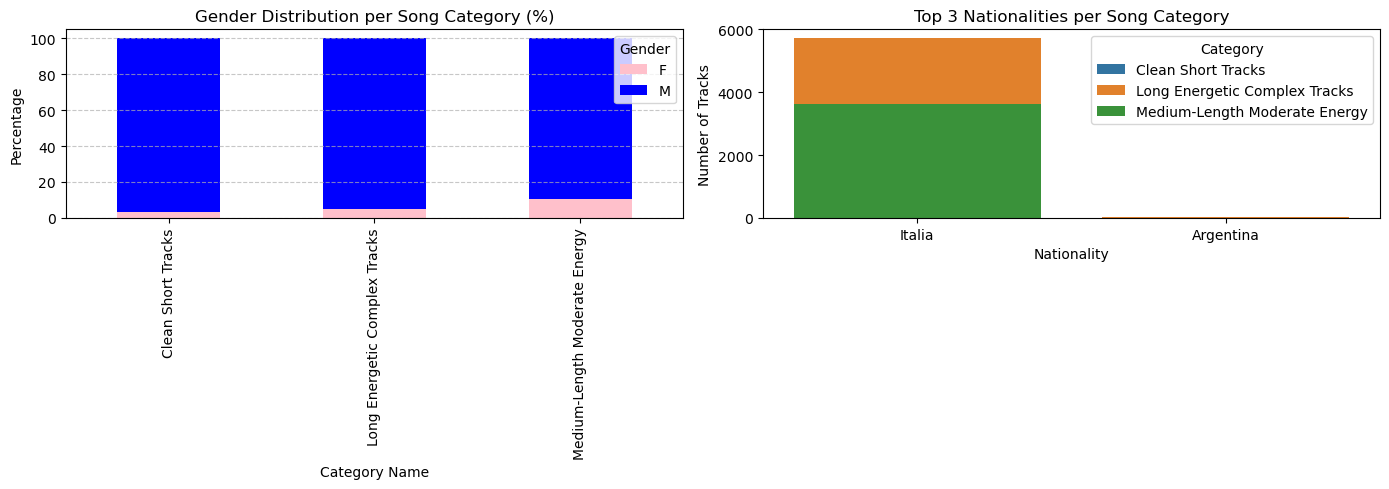

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare gender data
gender_analysis = df_song_profiles.groupby('Category_Name')['gender'].value_counts(normalize=True).mul(100).unstack(fill_value=0)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14,5))

# 1️⃣ Gender Distribution (Stacked Bar)
gender_analysis.plot(
    kind='bar',
    stacked=True,
    color={'M': 'blue', 'F': 'pink'},
    ax=axes[0]
)
axes[0].set_title("Gender Distribution per Song Category (%)")
axes[0].set_ylabel("Percentage")
axes[0].set_xlabel("Category Name")
axes[0].legend(title="Gender")
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# 2️⃣ Top 3 Nationalities per Category
for name, group in df_song_profiles.groupby('Category_Name'):
    top_nationalities = group['nationality'].value_counts().head(3)
    sns.barplot(
        x=top_nationalities.index,
        y=top_nationalities.values,
        label=name,
        ax=axes[1]
    )
axes[1].set_title("Top 3 Nationalities per Song Category")
axes[1].set_ylabel("Number of Tracks")
axes[1].set_xlabel("Nationality")
axes[1].legend(title="Category")

plt.tight_layout()
plt.show()


In [ ]:
###################################################

In [19]:
# Colonna 1: Assicurati che 'swear_IT_words' sia numerica
df_tracks['swear_IT_words'] = pd.to_numeric(
    df_tracks['swear_IT_words'], 
    errors='coerce' # Imposta a NaN se la conversione fallisce
)

# Colonna 2: Assicurati che 'swear_EN_words' sia numerica
df_tracks['swear_EN_words'] = pd.to_numeric(
    df_tracks['swear_EN_words'], 
    errors='coerce'
)

df_tracks['total_swears'] = df_tracks['swear_IT_words'].fillna(0) + df_tracks['swear_EN_words'].fillna(0)

In [22]:
df_tracks['swear_IT']['swear_EN'].head()

KeyError: 'swear_EN'

In [20]:
# Assumendo che 'swear_IT_words' e 'swear_EN_words' siano il conteggio totale di parolacce.
# Calcoliamo la densità di parolacce (per token totali, se hai 'n_tokens')
df_tracks['total_swears'] = df_tracks['swear_IT_words'] + df_tracks['swear_EN_words']

# Creazione di categorie logiche di contenuto (Imputazione concettuale per 'lyric_category'):
def classify_lyric_content(row):
    if row['total_swears'] > 15:
        return 'Contenuto Esplicito Forte'
    elif row['total_swears'] > 3:
        return 'Contenuto Leggermente Esplicito'
    else:
        return 'Contenuto Pulito'

df_tracks['lyric_category_swears'] = df_tracks.apply(classify_lyric_content, axis=1)

print("\nCategorizzazione basata sull'uso di parolacce:")
print(df_tracks['lyric_category_swears'].value_counts())


Categorizzazione basata sull'uso di parolacce:
lyric_category_swears
Contenuto Pulito    11166
Name: count, dtype: int64


In [18]:
# 1. Combinazione delle Categorie
df_tracks['song_profile_ID'] = df_tracks['audio_cluster'].astype(str) + '-' + df_tracks['lyric_category_swears']

print("\nProfili Complessivi:")
print(df_tracks['song_profile_ID'].value_counts())

# 2. Interpretazione dei Profili (Esempio)
# Analizziamo un profilo specifico (es. Cluster Audio 3 e Contenuto Esplicito Forte)
profile_3_strong = df_tracks[df_tracks['song_profile_ID'] == '3-Contenuto Esplicito Forte']

# Calcolo delle medie delle feature per questo profilo
mean_features = profile_3_strong[audio_features].mean()

# Esempio di Interpretazione:
print("\n--- Analisi del Profilo '3-Contenuto Esplicito Forte' ---")
print(f"Numero di brani in questo profilo: {len(profile_3_strong)}")
print(f"BPM Medio: {mean_features['bpm']:.1f}")
# Se il BPM è alto e il contenuto è esplicito, potremmo nominare il profilo:
# "Hip-Hop / Dance Energetica dal Contenuto Forte"

print("\n--- Categorie Finali Suggerite ---")
# 0-Contenuto Pulito: 'Pop Lento Acustico (Clean)'
# 3-Contenuto Esplicito Forte: 'Brano Rap/Dance Energetico (Explicit)'
# 1-Contenuto Pulito: 'Rock Classico (Pulito)'

# La definizione finale dei profili è un esercizio di business intelligence/interpretazione.


Profili Complessivi:
song_profile_ID
3.0-Contenuto Pulito    4007
1.0-Contenuto Pulito    3964
2.0-Contenuto Pulito    2857
0.0-Contenuto Pulito     274
nan-Contenuto Pulito      64
Name: count, dtype: int64

--- Analisi del Profilo '3-Contenuto Esplicito Forte' ---
Numero di brani in questo profilo: 0
BPM Medio: nan

--- Categorie Finali Suggerite ---
